In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout,CuDNNLSTM
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
import keras.utils as ku 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import string, os 
import matplotlib.pyplot as plt
from pickle import dump
import time
from keras.utils.vis_utils import plot_model

In [ ]:
df = pd.read_csv('/content/ASD_sequences_20_4.csv')# Processed dataset containing sequences of fixations and saccades
print(df.shape)
df = df[(df['label']==1)]#Selecting positive samples
print(df.shape)

(43979, 2)
(15709, 2)


In [ ]:
corpus = df['sequence'].astype(str).values.tolist()

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = 100
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
sequences[:10]

In [ ]:
# separate into input and output
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = 100 #X.shape[1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
nBatch =128
nEpoch= 20

In [ ]:
#LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(CuDNNLSTM(50))
model.add(Dense(25, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

#fit model
start = time.time()
hist = model.fit(X_train, y_train, batch_size=nBatch, validation_split=0.20, epochs=nEpoch)
end = time.time()
print("Training Time:", end - start, "seconds.")

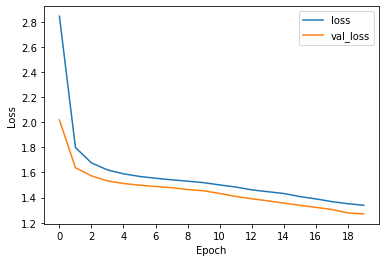

In [ ]:
hist_df = pd.DataFrame(hist.history)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xticks(np.arange(0, 20, step=2))
plt.savefig('Loss.png', dpi=300, quality=100)


In [ ]:
model.evaluate(x=X_test, y=y_test, batch_size=128, verbose=1)

In [ ]:
# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

In [ ]:
#Generaing sample sequences
seeds = ['ffff ssfs' ,'fsfs ssff' ]
for seed in seeds:
  generated = generate_seq(model, tokenizer, seq_length, seed, 1)
  print(generated)